In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact, yeojohnson
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, pearsonr
from sklearn.linear_model import LinearRegression
from bioinfokit import analys, visuz
from qqman import qqman
from matplotlib import rc
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

# Correlating mCAs with blood counts in TOPMed

## Data set with mCAs and blood counts

In [3]:
mca_pacer_nochrx_bloodcounts_df = pd.read_csv('mca_pacer_nochrx_bloodcounts_df.tsv', sep='\t')

In [4]:
mca_pacer_nochrx_bloodcounts_df

,sample.id,total_pass_mut,chip_case,age,sex,sex_dummy,mCAs,mCA,cf,mCA w arm,...,age_at_mch_entmass_rbc_1,mch_entmass_rbc_1,age_at_mchc_mcnc_rbc_1,mchc_mcnc_rbc_1,age_at_mcv_entvol_rbc_1,mcv_entvol_rbc_1,age_at_pmv_entvol_bld_1,pmv_entvol_bld_1,age_at_rdw_ratio_rbc_1,rdw_ratio_rbc_1
0,NWD617450,595,False,70.0,M,1,CN-LOH in chr13,13=,0.0152,13q=,...,NaN,NaN,67.0,31.746033,NaN,NaN,NaN,NaN,NaN,NaN
1,NWD873133,585,False,67.0,M,1,Loss in chr13,13-,0.2025,13q-,...,87.0,33.100000,64.0,32.932692,67.0,99.000000,87.0,8.3,87.0,14.5
2,NWD821780,468,False,53.0,M,1,Gain in chr20,20+,0.0392,20q+,...,59.0,31.899994,50.0,33.777778,53.0,88.000000,NaN,NaN,NaN,NaN
3,NWD749768,463,False,81.0,F,0,Gain in chr12,12+,0.5293,"12q+, 12+",...,NaN,NaN,81.0,34.491315,NaN,NaN,NaN,NaN,NaN,NaN
4,NWD646750,447,False,59.0,M,1,CN-LOH in chr14,14=,0.1411,14q=,...,62.0,32.799988,56.0,34.272300,59.0,91.000000,NaN,NaN,62.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,NWD477942,11,False,62.0,F,0,CN-LOH in chr3,3=,0.0127,3q=,...,62.0,31.407035,62.0,35.511364,62.0,88.442211,NaN,NaN,NaN,NaN
983,NWD204445,9,False,64.0,F,0,CN-LOH in chr11,11=,0.0274,11p=,...,64.0,30.270270,64.0,33.333333,64.0,90.810811,NaN,NaN,NaN,NaN
984,NWD901386,9,False,62.0,M,1,CN-LOH in chr11,11=,0.0263,11q=,...,62.0,30.470348,62.0,33.184855,62.0,91.820041,NaN,NaN,NaN,NaN
985,NWD205502,8,False,52.0,F,0,Undetermined in chr4,4U,0.0289,4qU,...,52.0,30.042918,52.0,33.573141,52.0,89.484979,NaN,NaN,NaN,NaN


In [5]:
len(mca_pacer_nochrx_bloodcounts_df)

987

987 total patients with mCAs and available blood counts

## Importing mCAs known to be associated with risk of lineage-specific hematologic malignancies (lymphoid and myeloid)

Sources: 
- Niroula A, Sekar A, Murakami MA, Trinder M, Agrawal M, Wong WJ, Bick AG, Uddin MM, Gibson CJ, Griffin GK, Honigberg MC, Zekavat SM, Paruchuri K, Natarajan P, Ebert BL. Distinction of lymphoid and myeloid clonal hematopoiesis. Nat Med. 2021 Nov;27(11):1921-1927. doi: 10.1038/s41591-021-01521-4. Epub 2021 Oct 18. PMID: 34663986; PMCID: PMC8621497.
- Table 1 from von Beck, K., von Beck, T., Ferrell, P.B. et al. Lymphoid clonal hematopoiesis: implications for malignancy, immunity, and treatment. Blood Cancer J. 13, 5 (2023). https://doi.org/10.1038/s41408-022-00773-8

Manually mapped LOH of specific genes to their chromosomal arm.

In [6]:
l_mcas = [
    '12+', 
    '13q-', 
    '10q-', 
    '8q=', #LOH ITPKB1
    '13q=', #LOH MIR16-1
    '9q=' #LOH NOTCH1
]

In [7]:
m_mcas = [
    '20q-',
    '5q-',
    '8+',
    '14q=', #LOH TCL1A
    '22q=', #LOH EP300
    '9q=', #LOH JAK2
]

In [8]:
mca_pacer_nochrx_bloodcounts_df['islmca'] = mca_pacer_nochrx_bloodcounts_df['mCA w arm'].apply(lambda x: 1 if x in l_mcas else 0)
mca_pacer_nochrx_bloodcounts_df['ismmca'] = mca_pacer_nochrx_bloodcounts_df['mCA w arm'].apply(lambda x: 1 if x in m_mcas else 0)

In [9]:
def get_ismca(row):
    if row['islmca'] == 1:
        return 'Lymphoid'
    elif row['ismmca'] == 1:
        return 'Myeloid'
    else:
        return 'none'

mca_pacer_nochrx_bloodcounts_df['ismca'] = mca_pacer_nochrx_bloodcounts_df.apply(get_ismca, axis=1)

In [10]:
mca_pacer_nochrx_bloodcounts_df['lymph:wbc'] = mca_pacer_nochrx_bloodcounts_df['lymphocyte_ncnc_bld_1']/mca_pacer_nochrx_bloodcounts_df['wbc_ncnc_bld_1']

In [11]:
mca_pacer_nochrx_bloodcounts_df['myeloid'] = mca_pacer_nochrx_bloodcounts_df['basophil_ncnc_bld_1'] + mca_pacer_nochrx_bloodcounts_df['eosinophil_ncnc_bld_1'] + mca_pacer_nochrx_bloodcounts_df['neutrophil_ncnc_bld_1'] + mca_pacer_nochrx_bloodcounts_df['monocyte_ncnc_bld_1']

In [12]:
mca_pacer_nochrx_bloodcounts_df_lm = mca_pacer_nochrx_bloodcounts_df.loc[mca_pacer_nochrx_bloodcounts_df['ismca']!='none']

In [13]:
mca_pacer_nochrx_bloodcounts_df.describe()['wbc_ncnc_bld_1']

count    987.000000
mean       6.731682
std        3.113819
min        1.600000
25%        5.200000
50%        6.400000
75%        7.600000
max       60.700000
Name: wbc_ncnc_bld_1, dtype: float64

## Histograms of blood counts amongst mCA patients

In [14]:
def plot_blood_counts_histogram(counts, cell_line):
    plt.hist(counts, bins=150, density=True)
    plt.ylabel('Fraction of mCA pts')
    plt.xlabel(cell_line + ' counts')
    plt.show()
    print("Min: " + str(min(counts)))
    print("Max: " + str(max(counts)))
    print("Median: " + str(stats.median(counts)))

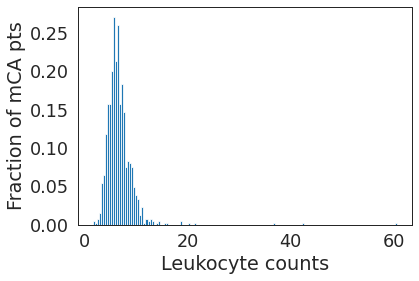

Min: 1.6
Max: 60.7
Median: 6.3999996185


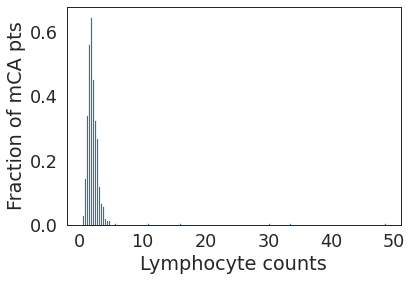

Min: 0.3432
Max: 48.7
Median: 1.8674


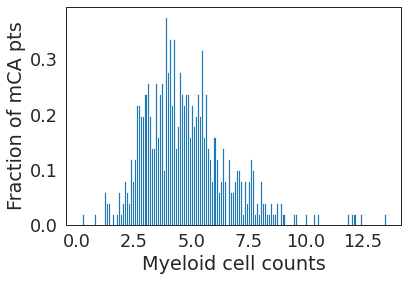

Min: 0.2
Max: 13.514999999999999
Median: 4.512


In [15]:
plot_blood_counts_histogram(mca_pacer_nochrx_bloodcounts_df['wbc_ncnc_bld_1'].dropna().to_numpy(), 'Leukocyte')
plot_blood_counts_histogram(mca_pacer_nochrx_bloodcounts_df['lymphocyte_ncnc_bld_1'].dropna().to_numpy(), 'Lymphocyte')
plot_blood_counts_histogram(mca_pacer_nochrx_bloodcounts_df['myeloid'].dropna().to_numpy(), 'Myeloid cell')

## Do blood counts vary for lymphoid and myeloid mCAs? 

In [16]:
def generate_violin_and_ttest(df, x_col, phenotype, xlab, ylab, xlabels):
    table = mca_pacer_nochrx_bloodcounts_df_lm.groupby(x_col).describe()[phenotype]
    ax = sns.violinplot(x = x_col, y = phenotype,
                data=df)
    plt.ylim(0, 2*max(table['mean']) + max(table['std']))
    ax.set(xlabel=xlab, ylabel= ylab)
    ax.set_xticklabels(xlabels)
    plt.show()
    unique_xcol_values = list(set(df[x_col]))
    print(unique_xcol_values)
    print(
        "p-value for t-test: " + 
        str(ttest_ind(df[df[x_col] == unique_xcol_values[0]][phenotype].dropna(), 
                    df.dropna()[df[x_col] == unique_xcol_values[1]][phenotype].dropna())[1]))
    return mca_pacer_nochrx_bloodcounts_df_lm.groupby(x_col).describe()[phenotype]

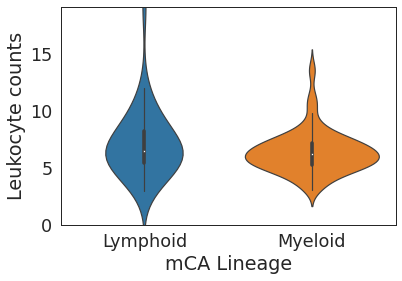

['Myeloid', 'Lymphoid']
p-value for t-test: 0.00022699920042937234


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,count,mean,std,min,25%,50%,75%,max
ismca,,,,,,,,
Lymphoid,98.0,7.407143,4.286282,2.9,5.4,6.5,8.2,36.9
Myeloid,147.0,6.376190,1.880518,3.0,5.2,6.2,7.2,14.0


In [17]:
generate_violin_and_ttest(mca_pacer_nochrx_bloodcounts_df_lm, 'ismca', 'wbc_ncnc_bld_1', 
                          'mCA Lineage', 'Leukocyte counts', ['Lymphoid', 'Myeloid'])

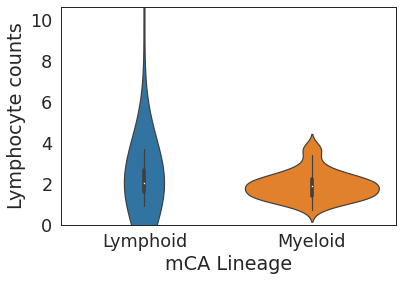

['Myeloid', 'Lymphoid']
p-value for t-test: 0.0004047189247547398


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,count,mean,std,min,25%,50%,75%,max
ismca,,,,,,,,
Lymphoid,52.0,3.062952,4.512622,0.9,1.57775,2.0125,2.6425,30.0735
Myeloid,88.0,1.919848,0.689429,0.7,1.39450,1.8700,2.2475,3.8700


In [18]:
generate_violin_and_ttest(mca_pacer_nochrx_bloodcounts_df_lm, 'ismca', 'lymphocyte_ncnc_bld_1',
                         'mCA Lineage', 'Lymphocyte counts', ['Lymphoid', 'Myeloid'])

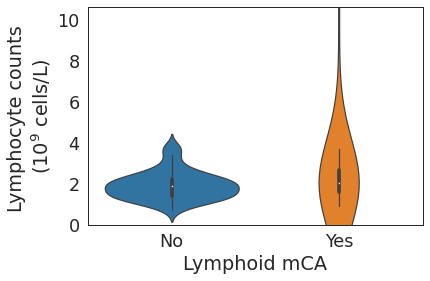

[0, 1]
p-value for t-test: 0.0004047189247547398


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,count,mean,std,min,25%,50%,75%,max
islmca,,,,,,,,
0,88.0,1.919848,0.689429,0.7,1.39450,1.8700,2.2475,3.8700
1,52.0,3.062952,4.512622,0.9,1.57775,2.0125,2.6425,30.0735


In [19]:
generate_violin_and_ttest(mca_pacer_nochrx_bloodcounts_df_lm, 'islmca', 'lymphocyte_ncnc_bld_1',
                         'Lymphoid mCA', 'Lymphocyte counts \n($10^{9}$ cells/L)', ['No', 'Yes'])

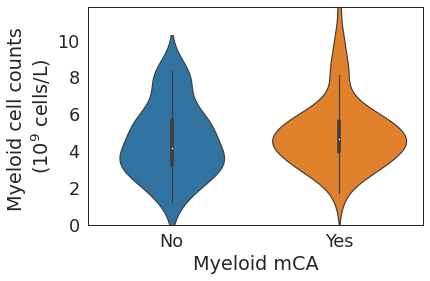

[0, 1]
p-value for t-test: 0.5443549794433564


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,count,mean,std,min,25%,50%,75%,max
ismmca,,,,,,,,
0,35.0,4.582843,1.930432,1.247,3.2225,4.1688,5.7000,8.4000
1,98.0,4.945134,1.882330,1.290,3.9225,4.6416,5.6435,12.0099


In [20]:
generate_violin_and_ttest(mca_pacer_nochrx_bloodcounts_df_lm, 'ismmca', 'myeloid',
                         'Myeloid mCA', 'Myeloid cell counts \n($10^{9}$ cells/L)', ['No', 'Yes'])

## For pts with lymphoid mCAs, does PACER correlate with blood counts?

### Multiple regression of: lymphocyte count ~ clonal expansion rate + age at blood draw 

In [22]:
df = mca_pacer_nochrx_bloodcounts_df_lm.loc[mca_pacer_nochrx_bloodcounts_df_lm['islmca'] == 1]
df = df[['total_pass_mut', 'age_at_lymphocyte_ncnc_bld_1', 'sex_dummy', 'lymphocyte_ncnc_bld_1']].dropna()
X = df[['total_pass_mut', 'age_at_lymphocyte_ncnc_bld_1', 'sex_dummy']]
y = df['lymphocyte_ncnc_bld_1']

X = sm.add_constant(X)

# Fit the linear regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the results summary
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     lymphocyte_ncnc_bld_1   R-squared:                       0.133
Model:                               OLS   Adj. R-squared:                  0.079
Method:                    Least Squares   F-statistic:                     2.453
Date:                   Mon, 21 Aug 2023   Prob (F-statistic):             0.0746
Time:                           16:19:42   Log-Likelihood:                -147.93
No. Observations:                     52   AIC:                             303.9
Df Residuals:                         48   BIC:                             311.7
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

### Same regression for myeloid cell lines

In [23]:
df = mca_pacer_nochrx_bloodcounts_df_lm.loc[mca_pacer_nochrx_bloodcounts_df_lm['ismmca'] == 1]
df = df[['total_pass_mut', 'age_at_lymphocyte_ncnc_bld_1', 'sex_dummy', 'myeloid']].dropna()
X = df[['total_pass_mut', 'age_at_lymphocyte_ncnc_bld_1', 'sex_dummy']]
y = df['myeloid']

X = sm.add_constant(X)

# Fit the linear regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                myeloid   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.143
Date:                Mon, 21 Aug 2023   Prob (F-statistic):              0.336
Time:                        16:19:46   Log-Likelihood:                -198.78
No. Observations:                  98   AIC:                             405.6
Df Residuals:                      94   BIC:                             415.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

# Is there differential fitness among lymphoid, myeloid, and neither mCAs?

In [24]:
def get_ismca(row):
    if row['islmca'] == 1:
        return 'Lymphoid'
    elif row['ismmca'] == 1:
        return 'Myeloid'
    else:
        return 'Neither'

mca_pacer_nochrx_bloodcounts_df['ismca'] = mca_pacer_nochrx_bloodcounts_df.apply(get_ismca, axis=1)

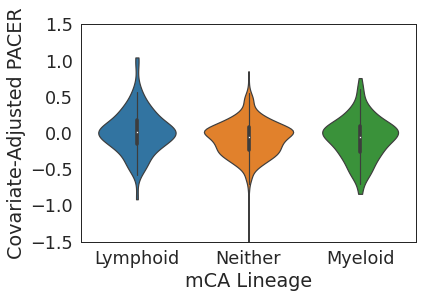

(             sum_sq     df         F    PR(>F)
 ismca      0.739033    2.0  5.362871  0.004825
 Residual  67.800327  984.0       NaN       NaN,
           count      mean       std       min       25%       50%      75%  \
 ismca                                                                        
 Lymphoid   98.0  0.016064  0.304334 -0.917408 -0.150131  0.016517  0.17852   
 Myeloid   147.0 -0.072834  0.291920 -0.842306 -0.258772 -0.057436  0.08795   
 Neither   742.0 -0.075869  0.250167 -1.527300 -0.241927 -0.061791  0.07892   
 
                max  
 ismca               
 Lymphoid  1.039292  
 Myeloid   0.754562  
 Neither   0.848401  )

In [25]:
table = mca_pacer_nochrx_bloodcounts_df.groupby('ismca').describe()['pacer_covadj_int_norm']
ax = sns.violinplot(x = 'ismca', y = 'pacer_covadj_int_norm',
            data=mca_pacer_nochrx_bloodcounts_df, cut=0)
plt.ylim(-1.5,1.5)
ax.set(xlabel='mCA Lineage', ylabel= 'Covariate-Adjusted PACER')
plt.show()
model = ols('pacer_covadj_int_norm ~ ismca', data=mca_pacer_nochrx_bloodcounts_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table, table

# Among lymphoid mCAs, is PACER correlated with lymphocyte counts?

0.23261274323696038 0.09702140563809492


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


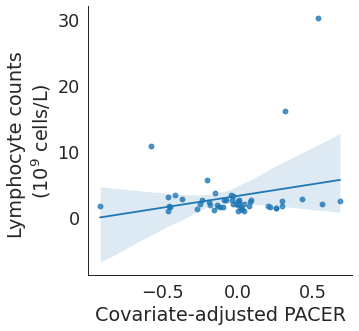

In [53]:
df = mca_pacer_nochrx_bloodcounts_df_lm.loc[mca_pacer_nochrx_bloodcounts_df_lm['islmca'] == 1]
df1 = df[['pacer_covadj_int_norm', 'lymphocyte_ncnc_bld_1']]
df1 = df1.dropna()
r, p = pearsonr(df1['pacer_covadj_int_norm'], df1['lymphocyte_ncnc_bld_1'])
print(r, p)
g = sns.lmplot('pacer_covadj_int_norm','lymphocyte_ncnc_bld_1', 
               data=df1)
plt.xlabel('Covariate-adjusted PACER')
plt.ylabel('Lymphocyte counts \n($10^{9}$ cells/L)')
plt.show()


-0.10007634264815528 0.32686008514751147


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


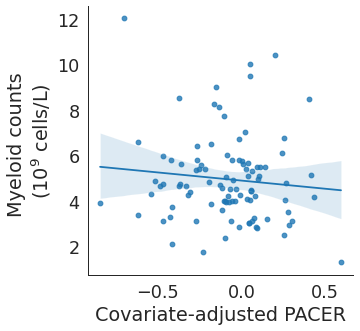

In [54]:
df = mca_pacer_nochrx_bloodcounts_df_lm.loc[mca_pacer_nochrx_bloodcounts_df_lm['ismmca'] == 1]
df1 = df[['pacer_covadj_int_norm', 'myeloid']]
df1 = df1.dropna()
r, p = pearsonr(df1['pacer_covadj_int_norm'], df1['myeloid'])
print(r, p)
g = sns.lmplot('pacer_covadj_int_norm','myeloid', 
               data=df1)
plt.xlabel('Covariate-adjusted PACER')
plt.ylabel('Myeloid counts \n($10^{9}$ cells/L)')
plt.show()
